In [2]:
from sqlalchemy import create_engine
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [3]:
DATABASE_LOCATION = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(DATABASE_LOCATION)

In [4]:
query = '''
SELECT 
    film.rental_rate, r.rental_id, cat.name AS 'film_category'
FROM
    rental AS r
        JOIN
    inventory AS inv USING (inventory_id)
        JOIN
    film AS film USING (film_id)
        JOIN
    film_category AS ficat USING (film_id)
        JOIN
    category AS cat USING (category_id);
'''

In [5]:
# Reading data and create dataframe
data = pd.read_sql_query(query, engine)
data.head()

,rental_rate,rental_id,film_category
0,0.99,10895,Action
1,0.99,12268,Action
2,0.99,3150,Action
3,0.99,5072,Action
4,0.99,9080,Action


In [6]:
data.shape


(16045, 3)

Analyze extracted features and transform them. You may need to encode 
 some categorical variables, or scale numerical variables.

In [7]:
data['rental_rate'] = data['rental_rate'].astype(object)

In [8]:
data.dtypes

rental_rate      object
rental_id         int64
film_category    object
dtype: object

###### 1.Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

In [9]:
query_2 = '''
SELECT 
    films.title,
    rentals.rental_id,
    YEAR(rentals.rental_date) = 2006
        AND MONTH(rentals.rental_date) = 2 AS 'rented_last_month',
    rentals.rental_date
FROM
    sakila.film AS films
        JOIN
    sakila.inventory AS inv USING (film_id)
        JOIN
    sakila.rental AS rentals USING (inventory_id);


'''

In [10]:
data_new = pd.read_sql_query(query_2,engine)
data_new.head()

,title,rental_id,rented_last_month,rental_date
0,ACADEMY DINOSAUR,4863,0,2005-07-08 19:03:15
1,ACADEMY DINOSAUR,11433,0,2005-08-02 20:13:10
2,ACADEMY DINOSAUR,14714,0,2005-08-21 21:27:43
3,ACADEMY DINOSAUR,16050,0,2022-07-21 21:13:17
4,ACADEMY DINOSAUR,972,0,2005-05-30 20:21:07


In [11]:
data_new = data_new.drop('rental_date', axis=1)
# Convert rented_last_month to boolean type
data_new['rented_last_month'] = data_new['rented_last_month'].astype(bool)
data_new.head()

,title,rental_id,rented_last_month
0,ACADEMY DINOSAUR,4863,False
1,ACADEMY DINOSAUR,11433,False
2,ACADEMY DINOSAUR,14714,False
3,ACADEMY DINOSAUR,16050,False
4,ACADEMY DINOSAUR,972,False


In [12]:
data = pd.merge(data, data_new, on='rental_id' )
data.head()

,rental_rate,rental_id,film_category,title,rented_last_month
0,0.99,10895,Action,AMADEUS HOLY,False
1,0.99,12268,Action,AMADEUS HOLY,False
2,0.99,3150,Action,AMADEUS HOLY,False
3,0.99,5072,Action,AMADEUS HOLY,False
4,0.99,9080,Action,AMADEUS HOLY,False


In [13]:
data = data.drop('rental_id', axis=1)

In [14]:
X_cat = data.select_dtypes(include=object)
X_cat.head()

,rental_rate,film_category,title
0,0.99,Action,AMADEUS HOLY
1,0.99,Action,AMADEUS HOLY
2,0.99,Action,AMADEUS HOLY
3,0.99,Action,AMADEUS HOLY
4,0.99,Action,AMADEUS HOLY


In [15]:
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()# Assigning numerical values and storing in another column

X_cat_encoded = pd.DataFrame()
X_cat_encoded['title_encoded'] = labelencoder.fit_transform(X_cat['title'])
X_cat_encoded

,title_encoded
0,17
1,17
2,17
3,17
4,17
...,...
16040,946
16041,946
16042,946
16043,946


In [16]:
X_cat

,rental_rate,film_category,title
0,0.99,Action,AMADEUS HOLY
1,0.99,Action,AMADEUS HOLY
2,0.99,Action,AMADEUS HOLY
3,0.99,Action,AMADEUS HOLY
4,0.99,Action,AMADEUS HOLY
...,...,...,...
16040,4.99,Travel,WORKING MICROCOSMOS
16041,4.99,Travel,WORKING MICROCOSMOS
16042,4.99,Travel,WORKING MICROCOSMOS
16043,4.99,Travel,WORKING MICROCOSMOS


In [17]:
X_cat_encoded

,title_encoded
0,17
1,17
2,17
3,17
4,17
...,...
16040,946
16041,946
16042,946
16043,946


One-Hot-Encoder using get_dummies

In [18]:
feature_encoded = pd.get_dummies(X_cat[['rental_rate', 'film_category']])
X_cat_encoded = X_cat_encoded.join(feature_encoded)
X_cat_encoded

,title_encoded,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,film_category_Action,film_category_Animation,film_category_Children,film_category_Classics,film_category_Comedy,film_category_Documentary,film_category_Drama,film_category_Family,film_category_Foreign,film_category_Games,film_category_Horror,film_category_Music,film_category_New,film_category_Sci-Fi,film_category_Sports,film_category_Travel
0,17,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,17,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,17,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,17,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16040,946,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
16041,946,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
16042,946,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
16043,946,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [19]:
Y = data['rented_last_month']
Y.head()

0    False
1    False
2    False
3    False
4    False
Name: rented_last_month, dtype: bool

In [20]:
X = X_cat_encoded

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

create a logistic regression model to predict this variable from the cleaned data.

###### Logistic Regression model

In [22]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\Elnaz.Allahbakhshi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

##### 6.Evaluate the results

In [23]:
y_predicted = model.predict(X_test)

In [24]:
model.score(X_test, y_predicted)

1.0

Text(51.0, 0.5, 'Truth')

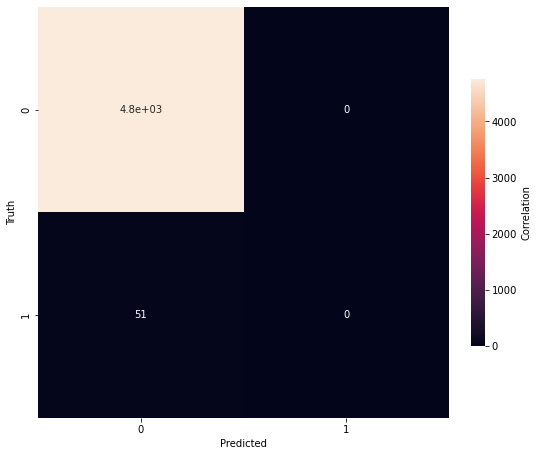

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_predicted)
y_predicted = model.predict(X_test)

plt.figure(figsize=(8,8))
sns.heatmap(cm, square=True, annot=True,
           cbar_kws={"orientation": "vertical", 'fraction': 0.03, 'label': 'Correlation'})
plt.xlabel('Predicted')
plt.ylabel('Truth')